# Climate Downscaling:

> * 🔬 Data Science
* 🤖 Machine Learning
* 🥠 Predictive Modeling
* 📈 Graphing and Visualization
* 🖥️ Requires ArcPy
* 👟 Ready To Run!

In this notebook, an essential component for making climate projections is addressed with spatial and non-spatial machine learning methods, namely climate downscaling. Downscaling is calibrating a global climate model with spatially-limited local temperature measurements.

For climate models, calibration can be done in various ways. One way of performing calibration is the so-called statistical downscaling that forms a statistical relationship between global climate models and temperature observations. For the inherently spatial problem of downscaling, we evaluate regression methods based on their method of handling spatial information.

1. Non-spatial (generic) machine learning
2. Spatial machine learning
3. Non-spatial machine learning with geoenriched predictors
  
## What is Statistical Climate Downscaling
### Overview
Scientists use Global Climate Models (GCMs) to model mesoscale to large scale (100s of kilometers) atmospheric dynamics of our planet. GCMs solve analytical equations, such as Navier-Stokes equations, to model global air flow and energy transfer in the atmosphere. In addition to global dynamics, weather is impacted by local effects such as distance to a water body, proximity to mountains, etc. These local effects are not modeled in GCMs. Thus, GCMs need to be calibrated with measurements collected at a finer scale. Fine-scale measurements of weather such as local temperature comes from weather stations that collect data continuously. In this analysis, we will be using weather measurements from a subset of weather stations in U.S. and CGCM1 climate model. Statistical downscaling is summarized below:

<img src=" 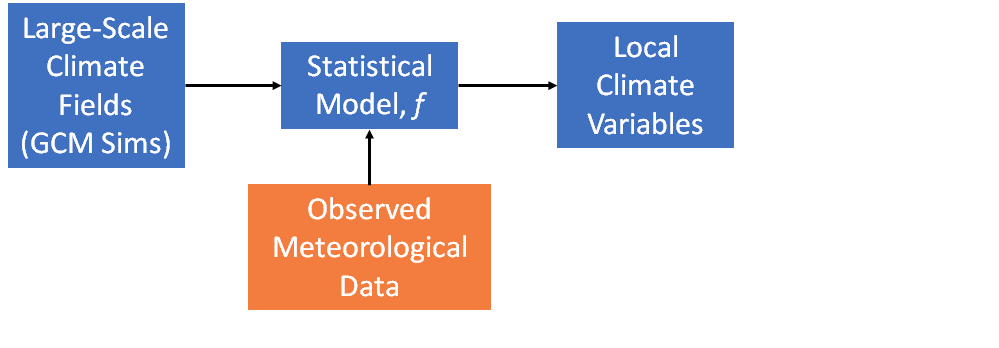">

### Predicting Climate Over Contiguous U.S.
Predicting future temperature using a GCM requires forming a statistically-valid relationship between coarse-scale climate model and fine-scale weather measurements using observed data. We will use 19 variables from CGCM1:

- Mean sea level pressure
- Airflow strength (simulated at 3 pressure levels)
- Surface zonal velocity (simulated at 3 pressure levels)
- Meridional velocity (simulated at 3 pressure levels)
- Surface vorticity (simulated at 3 pressure levels)
- Geopotential height (simulated 2 pressure levels)
- Zonal velocity (simulated at 2 pressure levels)
- Near surface relative humidity
- Near surface specific humidity

We will establish a relationship between simulated climate variables and measured average temperature to calibrate GCM. This process is known as downscaling and it can be done a number of ways (Wilby and Wigley, 1997). In this blog we will explore statistical downscaling. For the sake of demonstration, we will downscale GCM variables for a time snapshot: March 12, 2012 in the contiguous United States. 
Downscaling methods we will explore are summarized below.

<img src=" 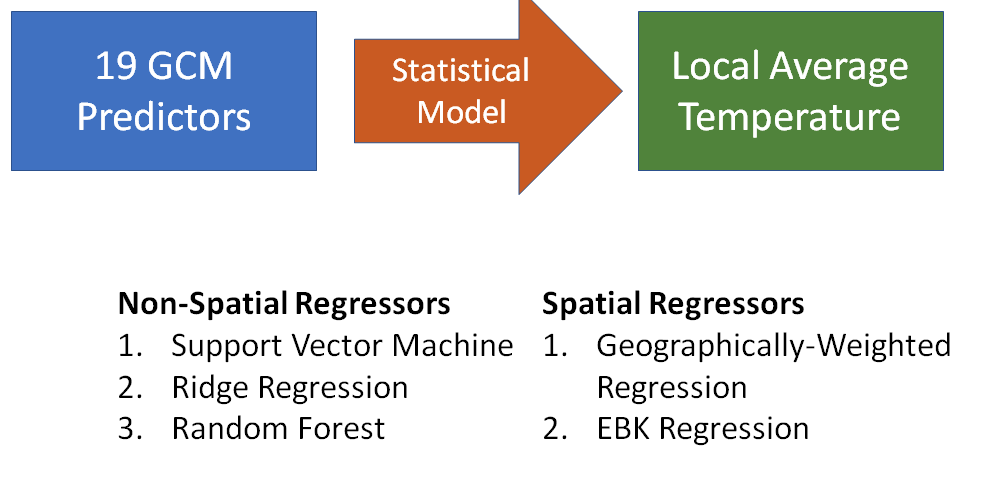">

## Approach
#### (1) Introduce Climate Downscaling
#### (2) Explain Regression Problem
#### (3) Methods we used: SVM/Ridge Regression method/GWR/RF

Let's get started.  First, we will import libraries that contain spatial and non-spatial regression models used throughout the study. In this notebook, we will use ArcPy and ArcGIS API for Python to perform spatial machine learning functions and data management, and scikit-learn will be used for non-spatial machine learning methods.

In [139]:
from arcgis.gis import GIS
import arcpy
from sklearn.linear_model import Ridge
from sklearn.svm import SVR

In [87]:
from IPython.display import display
display('https://arcgis.com/apps/Minimalist/index.html?appid=295c7fed9bbb413f8d8394b0effe1f71')

'https://arcgis.com/apps/Minimalist/index.html?appid=295c7fed9bbb413f8d8394b0effe1f71'

Even though it is a must, we recommend making sure ArcPy is properly imported by running the GetInstallInfo function and querying the version of the ArcPy installed on ArcGIS Notebook Server.

In [88]:
arcpy.GetInstallInfo()['Version']

'10.6.1'

Connect to GIS. GIS enables interactive widgets to be embedded in analytical work and internally uses the ArcGIS API for JavaScript.

In [89]:
agol_gis = GIS()

#### Automatically authenticate to your WebGIS using your credentials

In [90]:
gis = GIS("home", verify_cert=False)

#### Get started!

In [131]:
## Let's import other libraries we need
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import numpy as np
import shutil
import zipfile

## 0. Environment setting 

### 0.1 Unzip uploaded GDB 

In [92]:
from shutil import unpack_archive
# unpack_archive("/mnt/arcgis/me/climate_input.gdb.zip","/mnt/arcgis/me/")

## do not run more than once

Let's copy the sample geodatabase used from this sample from `/arcgis/samplesdata/` to `/arcgis/home`

In [ ]:
arcgis_dir = os.path.abspath(os.path.join(os.sep, 'arcgis', ''))
home_dir = os.path.join(arcgis_dir, 'home', '')

def copy_sample_gdb_to_home(gdb_zip_name):
    """Given the full filename (with extensions) of a gdb zip file in 
    /arcgis/samplesdata/, will copy and unzip that gdb to /arcgis/home/
    Will return the full path to the unzipped gdb in home"""

    # Get the full paths of all the source and destination files to copy
    gdb_dir_name = gdb_zip_name.split(".zip")[0]
    gdb_zip_path_src = os.path.join(arcgis_dir, 'samplesdata', 
                                    gdb_zip_name)
    gdb_dir_path_src = os.path.join(arcgis_dir, 'samplesdata', 
                                    gdb_dir_name)
    gdb_zip_path_dst = os.path.join(home_dir, gdb_zip_name)
    gdb_dir_path_dst = os.path.join(home_dir, gdb_dir_name)

    # If the gdb has been copied/unzipped to home dir before, delete it
    if os.path.exists(gdb_zip_path_dst):
        os.remove(gdb_zip_path_dst)
    if os.path.exists(gdb_dir_path_dst):
        shutil.rmtree(gdb_dir_path_dst)

    # Copy the zip file to home, unzip it
    shutil.copy(gdb_zip_path_src, gdb_zip_path_dst)
    zip_ref = zipfile.ZipFile(gdb_zip_path_dst, 'r')
    zip_ref.extractall(home_dir)
    zip_ref.close()
    
    # Return the output full path to /arcgis/home/unzipped_gdb/
    return os.path.join(gdb_dir_path_dst, '') # Adds trailing slash

gdb_path = copy_sample_gdb_to_home('climate_input.gdb.zip')
print(f"GDB succesfully copied to {gdb_path}")

### 0.2 Set up working environment

In [93]:
arcpy.env.workspace = gdb_path
outputSpace = home_dir
# arcpy.CreateFileGDB_management(outputSpace, "climate_output.gdb")  ## Do not need to run this function more than once
outGDB = os.path.join(outputSpace, "climate_output.gdb")

arcpy.env.overwriteOutput = True ## overwrite the output results

### 0.3 List the feature class in my working environment

In [95]:
datasets = arcpy.ListDatasets(feature_type='feature')
datasets = [''] + datasets if datasets is not None else []

## 1. Data Wrangling 
### 1.1 Filling Missing Station Values
#### There are a lot of them and we don't have much data to start with, so let's do FIMV.
#### There are some average surface temperature values are missing, and we need to fill the missing values.

In [96]:
station_fc = "station"

In [97]:
station_sdf = pd.DataFrame.spatial.from_featureclass(station_fc)

In [98]:
# show the temperature info from my station data
station_sdf[["T_MONTHLY_MAX", "T_MONTHLY_MIN", "T_MONTHLY_MEAN", "T_MONTHLY_AVG"]].head()

,T_MONTHLY_MAX,T_MONTHLY_MIN,T_MONTHLY_MEAN,T_MONTHLY_AVG
0,-9999.0,11.4,17.8,-9999.0
1,-9999.0,-9999.0,-9999.0,16.7
2,22.6,9.3,16.0,-9999.0
3,-9999.0,-9999.0,18.8,18.8
4,21.6,9.5,15.6,15.8


In [99]:
# As you can see, there are many -9999.0 in SUR_TEMP_MONTHLY_AVG. -9999 represents missing values, and we need to use fill mising value tool to fill those fields
# You can use the number of spatial neighbors for interpolating the missing values; here we'll use five numbers of neighbors

station_fmv = os.path.join(outGDB, "station_filled_missing_value")

arcpy.stpm.FillMissingValues(station_fc, station_fmv, "T_MONTHLY_MAX;T_MONTHLY_MIN;T_MONTHLY_MEAN;T_MONTHLY_AVG", "AVERAGE", "K_NEAREST_NEIGHBORS", None, None, "TIME", 6, "WBANNO", None, None, None, None, -9999, None)

<Result '/mnt/arcgis/me/climate_output.gdb/station_filled_missing_value'>

In [100]:
station_fmv_sdf = pd.DataFrame.spatial.from_featureclass(station_fmv)

station_fmv_sdf[["T_MONTHLY_MAX", "T_MONTHLY_MIN", "T_MONTHLY_MEAN", "T_MONTHLY_AVG"]].head()


# As the column (T_MONTHLY_AVG,T_MONTHLY_MIN, T_MONTHLY_MAX, T_MONTHLY_MEAN,) in the table shown below, the missing values are filled 
# Mention that the first entry is now filled

,T_MONTHLY_MAX,T_MONTHLY_MIN,T_MONTHLY_MEAN,T_MONTHLY_AVG
0,24.54,11.40,17.80,18.04
1,23.06,9.82,16.48,16.70
2,22.60,9.30,16.00,16.48
3,24.80,12.04,18.80,18.80
4,21.60,9.50,15.60,15.80


### 1.2 Plot Local Station Data

In [101]:
# create a function which is able to plot the spatially enabled data frame

def visualizeFeatureClassBySEDF(myMap, fc, renderer_type, method, class_count, col, colors, alpha, line_width):
    sdf = pd.DataFrame.spatial.from_featureclass(fc)
    sdf.spatial.project(spatial_reference = {'wkid': 3857}) # change the spatial reference of the spatial enabled data frame same as the map
    sdf.spatial.plot(map_widget= myMap,renderer_type=renderer_type, method=method, class_count=class_count, col=col,colors=colors,alpha=alpha, line_width=line_width)

In [102]:
# create map widget, but the zoom level doesn't work if we run it twice
sdf_map = GIS().map('United States',zoomlevel=4)
sdf_map
# sdf_map.center = [39,-1000] 

MapView(layout=Layout(height='400px', width='100%'), zoom=4.0)

In [103]:
visualizeFeatureClassBySEDF(sdf_map, station_fmv, renderer_type='c',method='esriClassifyNaturalBreaks',class_count=7,col="T_MONTHLY_AVG",colors='Reds' ,alpha=0.5, line_width=0.5)

### 1.3 Resolve Scale and Discretization Differences
Global climate modeling is simulated at locations around the world. One of the global climate variables is visualized.

In [104]:
# First, let's plot the GCM data

def visualizeFeatureClassBySEDF_unique(myMap, fc, symbol_type, cmap,line_width,marker_size, alpha):
    sdf = pd.DataFrame.spatial.from_featureclass(fc)
    sdf.spatial.project(spatial_reference = {'wkid': 3857}) # change the spatial reference of the spatially enabled data frame same as the map
    sdf.spatial.plot(map_widget= myMap,symbol_type=symbol_type,cmap=cmap,line_width=line_width, marker_size=marker_size)

In [105]:
# We add the GCM data to the map above; as you can see, the locations of GCM data points do not coincide with the locations of stations
visualizeFeatureClassBySEDF_unique(sdf_map, "airFlow500_201203", symbol_type='simple',cmap=[90,180,172,225] ,line_width= 0.5,marker_size=7, alpha="0.5")

In [106]:
# Since the locations of GCM data do not coincide with the locations of the real station, first, we need to interpolate GCM data and get the raster surfaces of GCM 

arcpy.env.extent = arcpy.Extent(-124.76308372794, 24.5230996116049, -66.9498936574818, 49.3843680121063)  # setting the extent as US polygon - this is important, as otherwise some parts of the US won't get the interpolated values
# run through a loop to create all GCM raster surfaces using EBK
gcm_lst = [("specHum2m_201203","shum"),("airT2m_201203","air"),("geoHgt850_201203","hgt"),("geoHgt500_201203","hgt"),("relHumSurf_201203","rhum"),
           ("specHum850_201203","shum"),("specHum500_201203","shum"),("vort850_201203","omega"),("vort500_201203","omega"),("merid850_201203","vwnd"),
          ("merid500_201203","vwnd"),("zonal850_201203","uwnd"),("zonal500_201203","uwnd"),("airFlow850_201203","wspd"),("airFlow500_201203","wspd"),
          ("airFlowSurf_201203","wspd"),("vortSurf_201203","wspd"),("meridSurf_201203","vwnd"),("seaLevP_201203","slp"),("zonalSurf_201203","uwnd")]

for gcm,value in gcm_lst:
    arcpy.env.workspace = home_dir + "/climate_input.gdb" # if we don't reset the current workspace, the file cannot be found in the second iteration
    file_name = str(gcm)+"_ebk_surface"
    output = os.path.join(outGDB, file_name)
    arcpy.ga.EmpiricalBayesianKriging(gcm, value, None, output, 9.94450736020055E-02, "NONE", 100, 1, 100, "NBRTYPE=StandardCircular RADIUS=15 ANGLE=0 NBR_MAX=15 NBR_MIN=10 SECTOR_TYPE=ONE_SECTOR", "PREDICTION", 0.5, "EXCEED", None, "POWER")
    
   

specHum2m_201203
shum
/mnt/arcgis/me/climate_output.gdb/specHum2m_201203_ebk_surface
airT2m_201203
air
/mnt/arcgis/me/climate_output.gdb/airT2m_201203_ebk_surface
geoHgt850_201203
hgt
/mnt/arcgis/me/climate_output.gdb/geoHgt850_201203_ebk_surface
geoHgt500_201203
hgt
/mnt/arcgis/me/climate_output.gdb/geoHgt500_201203_ebk_surface
relHumSurf_201203
rhum
/mnt/arcgis/me/climate_output.gdb/relHumSurf_201203_ebk_surface
specHum850_201203
shum
/mnt/arcgis/me/climate_output.gdb/specHum850_201203_ebk_surface
specHum500_201203
shum
/mnt/arcgis/me/climate_output.gdb/specHum500_201203_ebk_surface
vort850_201203
omega
/mnt/arcgis/me/climate_output.gdb/vort850_201203_ebk_surface
vort500_201203
omega
/mnt/arcgis/me/climate_output.gdb/vort500_201203_ebk_surface
merid850_201203
vwnd
/mnt/arcgis/me/climate_output.gdb/merid850_201203_ebk_surface
merid500_201203
vwnd
/mnt/arcgis/me/climate_output.gdb/merid500_201203_ebk_surface
zonal850_201203
uwnd
/mnt/arcgis/me/climate_output.gdb/zonal850_201203_ebk_sur

In [107]:
## We can list all raster files in the output gdb to make sure our EBK outputs are in there

# Reset the current workspace
arcpy.env.workspace = home_dir + "climate_output.gdb" 


In [108]:
# extract the values from the raster surface to the points of stations. the "extract multi value to points" method can help us to do that

arcpy.env.workspace = home_dir + "/climate_input.gdb"
# station = "station"

arcpy.CopyFeatures_management(station_fmv, home_dir + "/climate_output.gdb/station_GCM")  # since we don't want to change the original input station data, we make a copy to climate_output.gdb



arcpy.env.workspace = home_dir + "/climate_output.gdb"
arcpy.sa.ExtractMultiValuesToPoints("station_GCM", [["specHum2m_201203_ebk_surface", "specHum2m"], 
                           ["airT2m_201203_ebk_surface", "airT2m"], ["geoHgt850_201203_ebk_surface", "geoHgt850"],["geoHgt500_201203_ebk_surface","geoHgt500"],
                            ["relHumSurf_201203_ebk_surface","relHumSurf"],["specHum500_201203_ebk_surface","specHum500"],["specHum850_201203_ebk_surface","specHum850"],["vort850_201203_ebk_surface","vort850"],
                            ["vort500_201203_ebk_surface","vort500"],["merid850_201203_ebk_surface","merid850"],["merid500_201203_ebk_surface","merid500"],  
                            ["zonal850_201203_ebk_surface","zonal850"],["zonal500_201203_ebk_surface","zonal500"],["airFlow850_201203_ebk_surface","airFlow850"],
                            ["airFlow500_201203_ebk_surface","airFlow500"],["airFlowSurf_201203_ebk_surface","airFlowSurf"],["vortSurf_201203_ebk_surface","vortSurf"],
                            ["meridSurf_201203_ebk_surface","meridSurf"],["seaLevP_201203_ebk_surface","seaLevP"],["zonalSurf_201203_ebk_surface","zonalSurf"]], "NONE")

<geoprocessing server result object at 0x7fbf3d854be8>

In [115]:
# now the station data gets the values from 20 GCM raster surfaces, we can check them by listing the files in our data
arcpy.env.workspace = home_dir + "/climate_output.gdb"
fields = arcpy.ListFields("station_GCM")
station_predictors = ["airT2m","geoHgt850","geoHgt850","geoHgt500","relHumSurf","specHum500","specHum850","vort850","vort500","merid850","vort500","merid850", "merid500","zonal850","zonal500","airFlow850","airFlow500","airFlowSurf","vortSurf","meridSurf","seaLevP","zonalSurf"]
station_predictand = ["T_MONTHLY_AVG"]

In [120]:
# here are the variables we will use later
station_GCM = os.path.join(outGDB, "station_GCM")
station_GCM_sdf = pd.DataFrame.spatial.from_featureclass(station_GCM)
station_GCM_sdf[station_predictors + station_predictand].head()

,airT2m,geoHgt850,geoHgt850,geoHgt500,relHumSurf,specHum500,specHum850,vort850,vort500,merid850,...,zonal850,zonal500,airFlow850,airFlow500,airFlowSurf,vortSurf,meridSurf,seaLevP,zonalSurf,T_MONTHLY_AVG
0,289.849274,164.442810,164.442810,164.442810,84.123894,10.733871,10.733871,-0.000186,-0.000186,1.560577,...,-0.228084,-0.228084,4.300856,4.300856,3.480970,3.480970,1.641179,1019.500122,0.168260,18.04
1,288.776917,159.583572,159.583572,159.583572,81.954971,10.155290,10.155290,0.009753,0.009753,1.874455,...,0.081232,0.081232,4.569234,4.569234,4.803958,4.803958,2.306201,1018.818420,0.031793,16.70
2,288.779785,161.612015,161.612015,161.612015,82.472809,10.262587,10.262587,0.007003,0.007003,1.700639,...,0.011383,0.011383,4.380151,4.380151,4.402060,4.402060,2.013021,1019.115417,0.132166,16.48
3,292.476288,165.336426,165.336426,165.336426,83.303612,11.522986,11.522986,-0.002438,-0.002438,2.187334,...,-0.947109,-0.947109,4.986570,4.986570,3.740774,3.740774,1.571566,1019.343628,-0.971383,18.80
4,288.211456,163.101822,163.101822,163.101822,82.625290,10.282864,10.282864,0.005625,0.005625,1.584818,...,0.027670,0.027670,4.157624,4.157624,4.306197,4.306197,1.747083,1019.363281,0.216373,15.80


### 1.4 Create Prediction Location

Now, we have almost prepared all input data for our analysis, but we also need to prepare prediction locations. "US_Prediction_Grid" is the predicted grid that we created in advance, and we need to use the "Extract multi value to points" method again to extract values from raster surface data.

In [121]:
arcpy.env.workspace = home_dir + "/climate_input.gdb"
station = "US_Prediction_Grid"
arcpy.CopyFeatures_management(station, home_dir + "/climate_output.gdb/US_Prediction_Grid_GCM")  # since we don't want to change the original input US_Prediction_Grid data, we make a copy to climate_output.gdb



arcpy.env.workspace = home_dir + "/climate_output.gdb"
arcpy.sa.ExtractMultiValuesToPoints("US_Prediction_Grid_GCM", [["specHum2m_201203_ebk_surface", "specHum2m"], 
                           ["airT2m_201203_ebk_surface", "airT2m"], ["geoHgt850_201203_ebk_surface", "geoHgt850"],["geoHgt500_201203_ebk_surface","geoHgt500"],
                            ["relHumSurf_201203_ebk_surface","relHumSurf"],["specHum500_201203_ebk_surface","specHum500"],["specHum850_201203_ebk_surface","specHum850"],["vort850_201203_ebk_surface","vort850"],
                            ["vort500_201203_ebk_surface","vort500"],["merid850_201203_ebk_surface","merid850"],["merid500_201203_ebk_surface","merid500"],  
                            ["zonal850_201203_ebk_surface","zonal850"],["zonal500_201203_ebk_surface","zonal500"],["airFlow850_201203_ebk_surface","airFlow850"],
                            ["airFlow500_201203_ebk_surface","airFlow500"],["airFlowSurf_201203_ebk_surface","airFlowSurf"],["vortSurf_201203_ebk_surface","vortSurf"],
                            ["meridSurf_201203_ebk_surface","meridSurf"],["seaLevP_201203_ebk_surface","seaLevP"],["zonalSurf_201203_ebk_surface","zonalSurf"]], "NONE")

<geoprocessing server result object at 0x7fbf53b42350>

In [122]:
# now the US_Prediction_Grid data gets the values from 20 GCM raster surfaces
# we can check them by listing the files in our data
arcpy.env.workspace = home_dir + "/climate_output.gdb" 
fields = arcpy.ListFields("US_Prediction_Grid_GCM")

In [150]:
# Check the extracting data
US_Prediction_Grid_GCM = os.path.join(outGDB, "US_Prediction_Grid_GCM")      
output_GCM_sdf =  pd.DataFrame.spatial.from_featureclass(US_Prediction_Grid_GCM)
output_GCM_sdf.head()

,OBJECTID,FID_USdown,FID_US_pol,specHum2m,airT2m,geoHgt850,geoHgt500,relHumSurf,specHum500,specHum850,...,zonal850,zonal500,airFlow850,airFlow500,airFlowSurf,vortSurf,meridSurf,seaLevP,zonalSurf,SHAPE
0,1,184003,748,5.692194,278.807526,120.301033,120.301033,90.971458,6.022311,6.022311,...,0.508363,0.508363,4.972542,4.972542,4.116382,4.116382,3.275315,1014.533447,-0.888185,"{""x"": -124.47401777779817, ""y"": 42.84585442294..."
1,2,184004,748,5.601347,278.430908,120.403221,120.403221,90.464935,6.014113,6.014113,...,0.493984,0.493984,4.948649,4.948649,4.126608,4.126608,3.275623,1014.577087,-0.839869,"{""x"": -124.35839139734509, ""y"": 42.84585442294..."
2,3,184005,748,5.554446,278.235962,120.455879,120.455879,90.206520,6.009802,6.009802,...,0.486542,0.486542,4.936027,4.936027,4.131458,4.131458,3.275400,1014.599609,-0.815123,"{""x"": -124.24276501689201, ""y"": 42.84585442294..."
3,4,184006,748,5.506459,278.036133,120.509682,120.509682,89.944580,6.005348,6.005348,...,0.478930,0.478930,4.922931,4.922931,4.136118,4.136118,3.274896,1014.622620,-0.789958,"{""x"": -124.12713863733819, ""y"": 42.84585442294..."
4,5,184007,748,5.457265,277.830902,120.564690,120.564690,89.679047,6.000747,6.000747,...,0.471144,0.471144,4.909348,4.909348,4.140578,4.140578,3.274085,1014.646179,-0.764351,"{""x"": -124.01151225688511, ""y"": 42.84585442294..."


## 2. Explore the Relationship between variables 

In [124]:
station_GCM = os.path.join(outGDB, "station_GCM")
station_GCM_sdf =  pd.DataFrame.spatial.from_featureclass(station_GCM)

In [125]:
gcm_variables = station_GCM_sdf[station_predictors]

In [126]:
gcm_variables.head()

,airT2m,geoHgt850,geoHgt850,geoHgt500,relHumSurf,specHum500,specHum850,vort850,vort500,merid850,...,merid500,zonal850,zonal500,airFlow850,airFlow500,airFlowSurf,vortSurf,meridSurf,seaLevP,zonalSurf
0,289.849274,164.442810,164.442810,164.442810,84.123894,10.733871,10.733871,-0.000186,-0.000186,1.560577,...,1.560577,-0.228084,-0.228084,4.300856,4.300856,3.480970,3.480970,1.641179,1019.500122,0.168260
1,288.776917,159.583572,159.583572,159.583572,81.954971,10.155290,10.155290,0.009753,0.009753,1.874455,...,1.874455,0.081232,0.081232,4.569234,4.569234,4.803958,4.803958,2.306201,1018.818420,0.031793
2,288.779785,161.612015,161.612015,161.612015,82.472809,10.262587,10.262587,0.007003,0.007003,1.700639,...,1.700639,0.011383,0.011383,4.380151,4.380151,4.402060,4.402060,2.013021,1019.115417,0.132166
3,292.476288,165.336426,165.336426,165.336426,83.303612,11.522986,11.522986,-0.002438,-0.002438,2.187334,...,2.187334,-0.947109,-0.947109,4.986570,4.986570,3.740774,3.740774,1.571566,1019.343628,-0.971383
4,288.211456,163.101822,163.101822,163.101822,82.625290,10.282864,10.282864,0.005625,0.005625,1.584818,...,1.584818,0.027670,0.027670,4.157624,4.157624,4.306197,4.306197,1.747083,1019.363281,0.216373


In [127]:
# Let's create a correlation martix to check the relationship beteen variables
cor_table=gcm_variables.corr()
cor_table

,airT2m,geoHgt850,geoHgt850,geoHgt500,relHumSurf,specHum500,specHum850,vort850,vort500,merid850,...,merid500,zonal850,zonal500,airFlow850,airFlow500,airFlowSurf,vortSurf,meridSurf,seaLevP,zonalSurf
airT2m,1.000000,0.523595,0.523595,0.523595,0.024625,0.453730,0.453730,-0.158663,-0.158663,0.115316,...,0.115316,-0.511330,-0.511330,0.347245,0.347245,0.015663,0.015663,-0.023058,0.447370,-0.424246
geoHgt850,0.523595,1.000000,1.000000,1.000000,0.289894,0.494010,0.494010,-0.291139,-0.291139,-0.217254,...,-0.217254,-0.486172,-0.486172,-0.025858,-0.025858,-0.486138,-0.486138,-0.264269,0.988295,-0.476710
geoHgt850,0.523595,1.000000,1.000000,1.000000,0.289894,0.494010,0.494010,-0.291139,-0.291139,-0.217254,...,-0.217254,-0.486172,-0.486172,-0.025858,-0.025858,-0.486138,-0.486138,-0.264269,0.988295,-0.476710
geoHgt500,0.523595,1.000000,1.000000,1.000000,0.289894,0.494010,0.494010,-0.291139,-0.291139,-0.217254,...,-0.217254,-0.486172,-0.486172,-0.025858,-0.025858,-0.486138,-0.486138,-0.264269,0.988295,-0.476710
relHumSurf,0.024625,0.289894,0.289894,0.289894,1.000000,0.656593,0.656593,-0.077621,-0.077621,0.327945,...,0.327945,-0.486550,-0.486550,0.378382,0.378382,0.079718,0.079718,0.355055,0.345984,-0.514784
specHum500,0.453730,0.494010,0.494010,0.494010,0.656593,1.000000,1.000000,-0.002701,-0.002701,0.377895,...,0.377895,-0.661522,-0.661522,0.237232,0.237232,-0.040865,-0.040865,0.333374,0.511879,-0.591747
specHum850,0.453730,0.494010,0.494010,0.494010,0.656593,1.000000,1.000000,-0.002701,-0.002701,0.377895,...,0.377895,-0.661522,-0.661522,0.237232,0.237232,-0.040865,-0.040865,0.333374,0.511879,-0.591747
vort850,-0.158663,-0.291139,-0.291139,-0.291139,-0.077621,-0.002701,-0.002701,1.000000,1.000000,-0.190449,...,-0.190449,0.437495,0.437495,0.091095,0.091095,0.193072,0.193072,-0.185693,-0.270348,0.541757
vort500,-0.158663,-0.291139,-0.291139,-0.291139,-0.077621,-0.002701,-0.002701,1.000000,1.000000,-0.190449,...,-0.190449,0.437495,0.437495,0.091095,0.091095,0.193072,0.193072,-0.185693,-0.270348,0.541757
merid850,0.115316,-0.217254,-0.217254,-0.217254,0.327945,0.377895,0.377895,-0.190449,-0.190449,1.000000,...,1.000000,-0.377783,-0.377783,0.510803,0.510803,0.615815,0.615815,0.929742,-0.231816,-0.304112


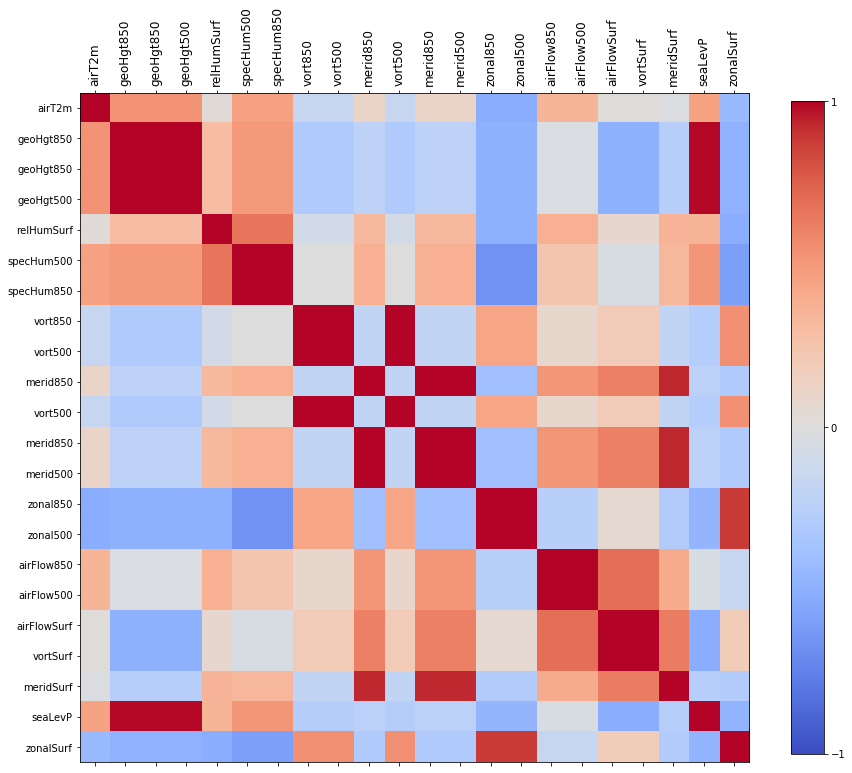

In [128]:
# colors make the correlation matrix more readable
size = 15
fig, ax = plt.subplots(figsize=(size, size))
cax = ax.matshow(cor_table,cmap=cm.get_cmap('coolwarm'), vmin=-1,vmax=1)
fig.colorbar(cax, ticks=[1,0,-1], shrink=0.8)
plt.xticks(range(len(gcm_variables.columns)), gcm_variables.columns, rotation='vertical', fontsize=12)
plt.yticks(range(len(gcm_variables.columns)), gcm_variables.columns)

plt.show()

## 3. Analysis:  Average Temperature Prediction

### 3.1 Support Vector Machine (SVM) VS. Ridge Regression
#### 3.1.1. Ridge Regression for Climate Downscaling

In [129]:
ridge = RidgeCV(alphas=np.logspace(-10, 10, 10), fit_intercept = True, normalize = True, store_cv_values = True)
ridge.fit(station_GCM_sdf[station_predictors], station_GCM_sdf[station_predictand])

RidgeCV(alphas=array([1.00000e-10, 1.66810e-08, 2.78256e-06, 4.64159e-04, 7.74264e-02,
       1.29155e+01, 2.15443e+03, 3.59381e+05, 5.99484e+07, 1.00000e+10]),
    cv=None, fit_intercept=True, gcv_mode=None, normalize=True,
    scoring=None, store_cv_values=True)

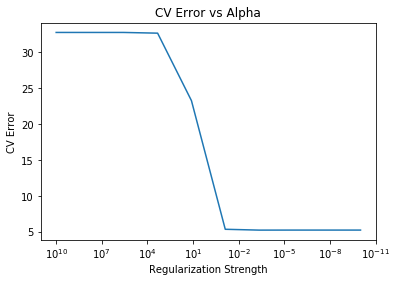

In [134]:
ax = plt.gca()
ax.plot(ridge.alphas.ravel(), np.mean(ridge.cv_values_, axis = 0).ravel())
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('Regularization Strength')
plt.ylabel('CV Error')
plt.title('CV Error vs Alpha')
plt.axis('tight')
plt.show()

In [138]:
print('Optimal Regularization Parameter = {0}'.format(ridge.alpha_))

Optimal Regularization Parameter = 0.0004641588833612782


#### 3.1.2 Support Vector Machine for Climate Downscaling

In [148]:
svr_rbf = SVR(kernel= 'rbf', C = 1.0, gamma='auto').fit(station_GCM_sdf[station_predictors], station_GCM_sdf[station_predictand])

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [151]:
svr_rbf.predict(output_GCM_sdf[station_predictors])

array([ 9.20849695,  9.21572404,  9.22601422, ..., 11.52765126,
       11.5663626 , 11.58317625])

In [145]:
from IPython.display import IFrame
IFrame(src='https://eath.maps.arcgis.com/apps/StorytellingSwipe/index.html?appid=ca2c84c6611140f6883f9843c06d1d56#',
       width="100%", height="800px") 

### 3.2 EBK Regression Prediction  VS.  Geographically Weighted Regression (GWR)

In [181]:
# Let's use EBK regression to predict average temperature
arcpy.env.workspace = home_dir + "/climate_output.gdb"
input_feature = station_fmv
out_ga_layer = "EBK_pred_ga"
out_raster = "EBK_pred_raster"

arcpy.ga.EBKRegressionPrediction(station_fmv, "T_MONTHLY_AVG", "vort850_201203_ebk_surface;specHum850_201203_ebk_surface;zonalSurf_201203_ebk_surface", out_ga_layer, out_raster, 
 
                                 None, None, 95, None, "NONE", "EXPONENTIAL", 100, 1, 100, "NBRTYPE=StandardCircular RADIUS=15 ANGLE=0 NBR_MAX=15 NBR_MIN=10 SECTOR_TYPE=ONE_SECTOR")



# arcpy.ga.EBKRegressionPrediction(station_fmv, "T_MONTHLY_AVG", "zonalSurf_201203_ebk_surface;zonal850_201203_ebk_surface;zonal500_201203_ebk_surface;\
#                                  vortSurf_201203_ebk_surface;vort850_201203_ebk_surface;vort500_201203_ebk_surface;specHum850_201203_ebk_surface;\
#                                  specHum500_201203_ebk_surface;specHum2m_201203_ebk_surface;seaLevP_201203_ebk_surface;relHumSurf_201203_ebk_surface;\
#                                  meridSurf_201203_ebk_surface;merid850_201203_ebk_surface;merid500_201203_ebk_surface;geoHgt850_201203_ebk_surface;\
#                                  geoHgt500_201203_ebk_surface;airT2m_201203_ebk_surface;airFlowSurf_201203_ebk_surface;airFlow850_201203_ebk_surface;\
#                                  airFlow500_201203_ebk_surface", out_ga_layer, out_raster, 
#                                  None, None, 95, None, "NONE", "EXPONENTIAL", 100, 1, 100, "NBRTYPE=StandardCircular RADIUS=15 ANGLE=0 NBR_MAX=15 NBR_MIN=10 SECTOR_TYPE=ONE_SECTOR")


<Result 'EBK_pred_ga'>

In [182]:
# Now, we use GWR to predict average temperature and compare the result with EBK

arcpy.env.workspace = home_dir + "/climate_output.gdb"
input_feature = station_GCM
out_feature_class = os.path.join(outGDB, "GWR_out_feature_class")
kernal = "ADAPTIVE"
number_of_neighbor = 30
prediction_location = "US_Prediction_Grid_GCM"
prediction_output = "GWR_pred"

arcpy.stats.GeographicallyWeightedRegression(input_feature, "T_MONTHLY_AVG", 
                                             "specHum850;vort850;zonalSurf", 
                                             out_feature_class, kernal,"BANDWIDTH_PARAMETER", 
                                             None, number_of_neighbor, None, None, 9.22719999999999E-02, 
                                             prediction_location,"specHum850;vort850;zonalSurf",prediction_output)


# arcpy.stats.GeographicallyWeightedRegression(input_feature, "T_MONTHLY_AVG", 
#                                              "airFlow500;airFlow850;airFlowSurf;airT2m;\
#                                              geoHgt500;geoHgt850;merid500e;merid850;\
#                                              meridSurf;relHumSurf;seaLevP;specHum2m;\
#                                              specHum500;specHum850;vort500;vort850;\
#                                              vortSurf;zonal500;zonal850;zonalSurf", 
#                                              out_feature_class, kernal,"BANDWIDTH_PARAMETER", None, number_of_neighbor, None, None, 9.22719999999999E-02, prediction_location,
#                                              "airFlow500;airFlow850;airFlowSurf;airT2m;\
#                                              geoHgt500;geoHgt850;merid500e;merid850;\
#                                              meridSurf;relHumSurf;seaLevP;specHum2m;\
#                                              specHum500;specHum850;vort500;vort850;\
#                                              vortSurf;zonal500;zonal850;zonalSurf",prediction_output)

<Result '/mnt/arcgis/me/climate_output.gdb/GWR_out_feature_class'>

In [26]:
from IPython.display import IFrame
IFrame(src='https://eath.maps.arcgis.com/apps/StorytellingSwipe/index.html?appid=fe637afce2a4436db5332d08704722e2#',
       width="100%", height="800px") 

In [183]:
# The predicted output using GWR tool is point type. To better visualize continouous value (temperature), we convert the points result into raster with point to raster method. 
arcpy.env.workspace = home_dir + "/climate_output.gdb" 
input_feature = "GWR_pred"
output_result = "GWR_pred_raster"
assignmentType = "MEAN"
priorityField = ""
cellSize = "2000"

arcpy.PointToRaster_conversion(input_feature, "PREDICTED", 
                                output_result, assignmentType, priorityField, cellSize)

<Result '/mnt/arcgis/me/climate_output.gdb/GWR_pred_raster'>


### 3.3 Forest-Based Classification and Regression VS. Forest-Based Classification and Regression with Distance Features 

In [185]:
# use Forest-Based Classification and Regression method to predict average temperature

arcpy.env.workspace = home_dir + "/climate_output.gdb"
input_feature = "station_GCM"
predict_location = "US_Prediction_Grid_GCM"
output_result = "RF_pred"


arcpy.stats.Forest("PREDICT_FEATURES", input_feature, "T_MONTHLY_AVG", None,  "zonalSurf false;zonal850 false;zonal500 false;\
                    vortSurf false;vort850 false;vort500 false;specHum850 false;specHum500 false;specHum2m false;\
                    seaLevP false;relHumSurf false;meridSurf false;merid850 false;merid500 false;geoHgt850 false;\
                    geoHgt500 false;airT2m false;airFlowSurf false;airFlow850 false;airFlow500 false", None, None, predict_location,
                    output_result, None, "specHum2m specHum2m;airT2m airT2m;geoHgt850 geoHgt850;geoHgt500 geoHgt500;relHumSurf relHumSurf;specHum850 specHum850;\
                    vort850 vort850;vort500 vort500;merid850 merid850;merid500 merid500; zonal850 zonal850;zonal500 zonal500; airFlow850 airFlow850;airFlow500 airFlow500\
                    airFlowSurf airFlowSurf; vortSurf vortSurf; meridSurf meridSurf;seaLevP seaLevP;zonalSurf zonalSurf", None, None, None, None, "TRUE", 100, None, None, 100, None, 10)

<Result '/mnt/arcgis/me/climate_output.gdb/RF_pred'>

In [186]:
# The predicted output using Forest-Based Classification and Regression method is point type. To better visualize continouous value (temperature), we convert the points result into raster with 
# point to raster method. 
arcpy.env.workspace = home_dir + "/climate_output.gdb"
input_feature = "RF_pred"
output_result = "RF_pred_raster"
assignmentType = "MEAN"
priorityField = ""
cellSize = "2000"

arcpy.PointToRaster_conversion(input_feature, "PREDICTED", 
                                output_result, assignmentType, priorityField, cellSize)



<Result '/mnt/arcgis/me/climate_output.gdb/RF_pred_raster'>

In [188]:
# The power of GIS is that we consider space, so next, we include the distance of water body to our analysis
arcpy.env.workspace = home_dir + "/climate_output.gdb"
input_feature = "station_GCM"
output_result = "RF_pred_water_body"
distance_feature = home_dir + "/climate_input.gdb/water_body"

arcpy.stats.Forest("PREDICT_FEATURES", input_feature, "T_MONTHLY_AVG", None,  "zonalSurf false;zonal850 false;zonal500 false;\
                    vortSurf false;vort850 false;vort500 false;specHum850 false;specHum500 false;specHum2m false;\
                    seaLevP false;relHumSurf false;meridSurf false;merid850 false;merid500 false;geoHgt850 false;\
                    geoHgt500 false;airT2m false;airFlowSurf false;airFlow850 false;airFlow500 false", distance_feature, None, "US_Prediction_Grid_GCM",
                    output_result, None, "specHum2m specHum2m;airT2m airT2m;geoHgt850 geoHgt850;geoHgt500 geoHgt500;relHumSurf relHumSurf;specHum850 specHum850;\
                    vort850 vort850;vort500 vort500;merid850 merid850;merid500 merid500; zonal850 zonal850;zonal500 zonal500; airFlow850 airFlow850;airFlow500 airFlow500\
                    airFlowSurf airFlowSurf; vortSurf vortSurf; meridSurf meridSurf;seaLevP seaLevP;zonalSurf zonalSurf", None, None, None, None, "TRUE", 100, None, None, 100, None, 10)


<Result '/mnt/arcgis/me/climate_output.gdb/RF_pred_water_body'>

In [152]:
from IPython.display import IFrame
IFrame(src='https://eath.maps.arcgis.com/apps/StorytellingSwipe/index.html?appid=409a3bf73fca49c1a8cc77c20900f30d#',
       width="100%", height="800px") 

### Conclusions
In this study, we explored different means of incorporating spatial information in climate model downscaling.